# HOMEWORK 1

### load the modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from functools import partial

### define the functions

In [3]:
from scipy.special import gamma
from scipy.special import kv

def zero_mean(x):
    return 0*x 

def general_squared_exp_kernel(x1,x2,lenght=1):
    assert lenght > 0
    x1 = x1.reshape((-1, 1))
    x2 = x2.reshape((1, -1))
    dist = (x1-x2)/lenght 
    return np.exp(-dist*dist)

def general_matern_kernel(x1,x2,lenght,nu):
    assert lenght > 0
    assert nu > 0 
    x1 = x1.reshape((-1, 1))
    x2 = x2.reshape((1, -1))
    dist = np.sqrt(2*nu)*np.abs(x1-x2)/lenght
    tmp1 = 2*(dist/2)**nu/gamma(nu)
    tmp2 = kv(nu,dist)  
    return np.where(dist==0,1.0,tmp1*tmp2)

def draw_GP_prior_samples_at_x_grid(x_grid_G=None, 
                                    mean_func=None, 
                                    cov_func=None,
                                    random_seed=42,
                                    n_samples=1):
    """ Draw sample from GP prior given mean/cov functions

    Args
    ----
    x_grid_G : 1D array, size n_grid_pts (G)
        Contains G specific x_i values to evaluate function at
    mean_func : function, maps (1D arr size A) to (1D arr size A)
        Computes mean value $m(x_i)$ at each input x_i value 
    cov_func : function, maps (1D arr size A, 1D arr size B) to (2D AxB)
        Computes covariance (kernel) value at each pair of inputs.
    random_seed : int
        See for the random number generator
    n_samples : int
        Number of samples to draw from the prior

    Returns
    -------
    f_SG : 2D array, n_samples (S) x n_grid_pts (G)
        Contains sampled function values at each point of x_grid
    """
    # compute avergae and covariance at the grid points
    mean = mean_func(x_grid_G)
    cov = cov_func(x_grid_G,x_grid_G)
    #print(mean)
    #print(cov)
    
    # Use consistent random number generator for reproducibility
    prng = np.random.RandomState(int(random_seed))
    y = prng.multivariate_normal(mean, cov, size=n_samples)
    
    # Manual way to sample from multivariate normal
    #z = np.random.randn(G, n_samples)  # sample from N(0,I)
    #u, s, vh = np.linalg.svd(cov, full_matrices=True)  #facot cov = u*s*vh
    #z_tmp = np.sqrt(s.reshape(-1,1))*z  
    #y = mean + np.matmul(u,z_tmp).T  # y = mean + u * sqrt(s) * z
    return y

def draw_GP_posterior_samples_at_x_grid(
        x_train_N, y_train_N, x_grid_G, mean_func, cov_func,
        sigma=0.1,
        random_seed=42,
        n_samples=1):
    """ Draw sample from GP posterior given training data and mean/cov

    Args
    ----
    x_train_N : 1D array, size n_train_examples (N)
        Each entry i provides the x value observed at training example i 
    y_train_N : 1D array, size n_train_examples (N)
        Each entry i provides the y value observed at training example i 
    sigma : scalar float
        Specifies the standard deviation of the likelihood.
        y_i drawn from a 1D Normal with mean f(x_i) and std. dev. \sigma.
    Other args same as earlier function: draw_GP_prior_samples_at_x_grid

    Returns
    -------
    f_SG : 2D array, n_samples (S) x n_grid_pts (G)
        Contains sampled function values at each point of x_grid
    """
    # I use suffix "a" for unobserved and "b" for observed points
    mean_a = mean_func(x_grid_G)
    mean_b = mean_func(x_train_N)
    Kaa = cov_func(x_grid_G, x_grid_G)  
    Kab = cov_func(x_grid_G, x_train_N)
    Kba = Kab.T
    Kbb = cov_func(x_train_N, x_train_N)
    Maa = Kaa + sigma*sigma*np.identity(Kaa.shape[0])
    Mbb = Kbb + sigma*sigma*np.identity(Kbb.shape[0])
    
    # this is the expensive step
    M_inv = np.linalg.inv(Mbb)  # this is cubic in the number of observed points
    
    # compute the posterior mean and covariance
    tmp = np.dot(Kab,M_inv)
    tmp2 = (y_train_N-mean_b).T
    mean = mean_a + np.matmul(tmp,tmp2).reshape(-1)
    cov = Maa - np.matmul(tmp, Kba)
    
    # now it is the same as sampling from prior
    prng = np.random.RandomState(int(random_seed))
    y = prng.multivariate_normal(mean, cov, size=n_samples)
    return y
    

The sampling from prior function is based on following threee steps:
* sample from unit normal, i.e. $z \sim N(0,I)$
* decompose covariance matrix using singular value decomposition, i.e. $U*S*V^H = \text{covariance}$
* sample from Normal with arbitrary mean and covariance, i.e. $y = \text{mean} + U*sqrt(S)*z \sim N(\text{mean},\text{covariance})$


The sampling on posterior is based on:
<img src="inference_in_gaussians.png">

### Test Sample from prior

Text(0.5, 1.0, 'Curves sampled from prior')

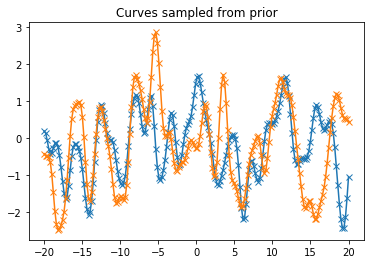

In [4]:
G = 200 # number of data points
l=1.0
x_grid_G = np.linspace(-20, 20, G)
y = draw_GP_prior_samples_at_x_grid(x_grid_G, 
                                    mean_func = zero_mean, 
                                    cov_func = general_squared_exp_kernel, 
                                    random_seed=42,
                                    n_samples=2)
prior = plt.plot(x_grid_G,y.T,'x-')
plt.title("Curves sampled from prior")

### Sample from posterior

In [5]:
# draw N training points
N_sampled = 5
x_train_N = -20+40*np.random.rand(N_sampled)
y_train_N = draw_GP_prior_samples_at_x_grid(x_train_N, 
                                            mean_func = zero_mean, 
                                            cov_func = partial(general_squared_exp_kernel,lenght=1), 
                                            random_seed=42,
                                            n_samples=1)



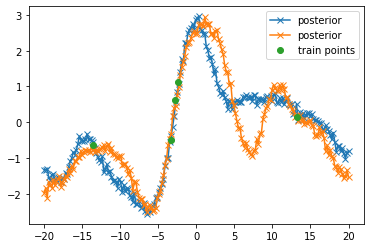

In [6]:
G = 200
x_grid_G = np.linspace(-20, 20, G)
y = draw_GP_posterior_samples_at_x_grid(x_train_N, y_train_N, x_grid_G, 
                                        mean_func = zero_mean, 
                                        cov_func = partial(general_squared_exp_kernel,lenght=4),
                                        sigma=0.1,
                                        random_seed=42,
                                        n_samples=2)

prior = plt.plot(x_grid_G,y.T,'x-',label='posterior')
plt.plot(x_train_N,y_train_N.T,'o',label='train points')
plt.legend()

### Exarcise 1: Sample from prior with squared exponential kernel with different lenghts

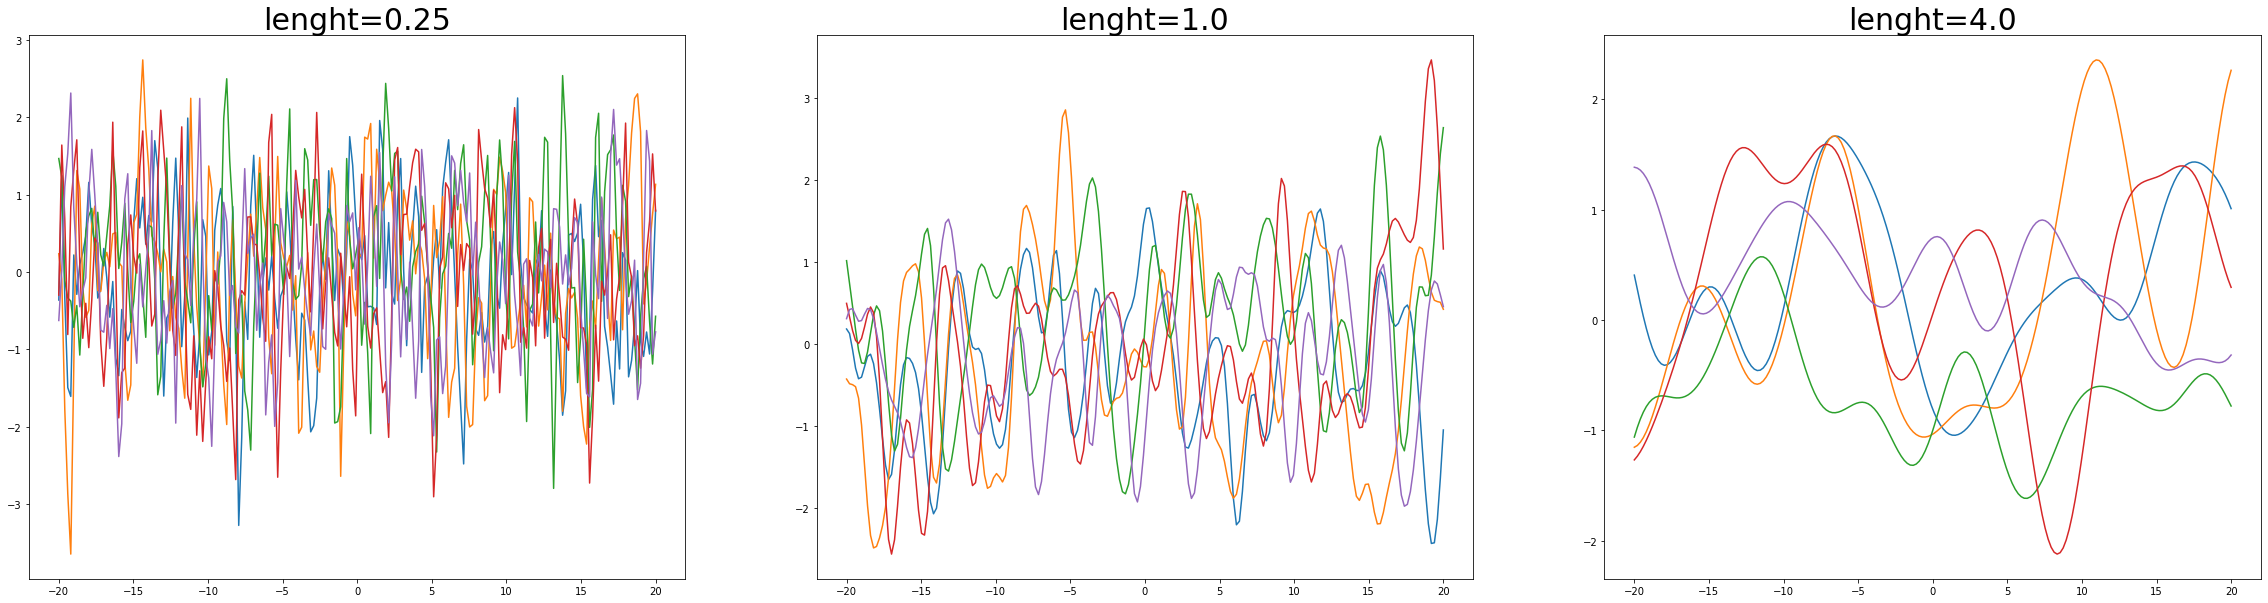

In [7]:
y0 = draw_GP_prior_samples_at_x_grid(x_grid_G, 
                                     mean_func = zero_mean, 
                                     cov_func = partial(general_squared_exp_kernel,lenght=0.25),
                                     random_seed=42,
                                     n_samples=5)
y1 = draw_GP_prior_samples_at_x_grid(x_grid_G, 
                                     mean_func = zero_mean, 
                                     cov_func = partial(general_squared_exp_kernel,lenght=1.0),
                                     random_seed=42,
                                     n_samples=5)
y2 = draw_GP_prior_samples_at_x_grid(x_grid_G, 
                                     mean_func = zero_mean, 
                                     cov_func = partial(general_squared_exp_kernel,lenght=4.0),
                                     random_seed=42,
                                     n_samples=5)

fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=False, figsize=(40, 10))
axs[0].set_title('lenght=0.25', fontsize=30)
a = axs[0].plot(x_grid_G,y0.T)
axs[1].set_title('lenght=1.0', fontsize=30)
a = axs[1].plot(x_grid_G,y1.T)
axs[2].set_title('lenght=4.0', fontsize=30)
a = axs[2].plot(x_grid_G,y2.T)

### Exarcise 2: Sample from prior with different Matern kernel

/Users/ldalessi/anaconda3/envs/bdl_2019f_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply


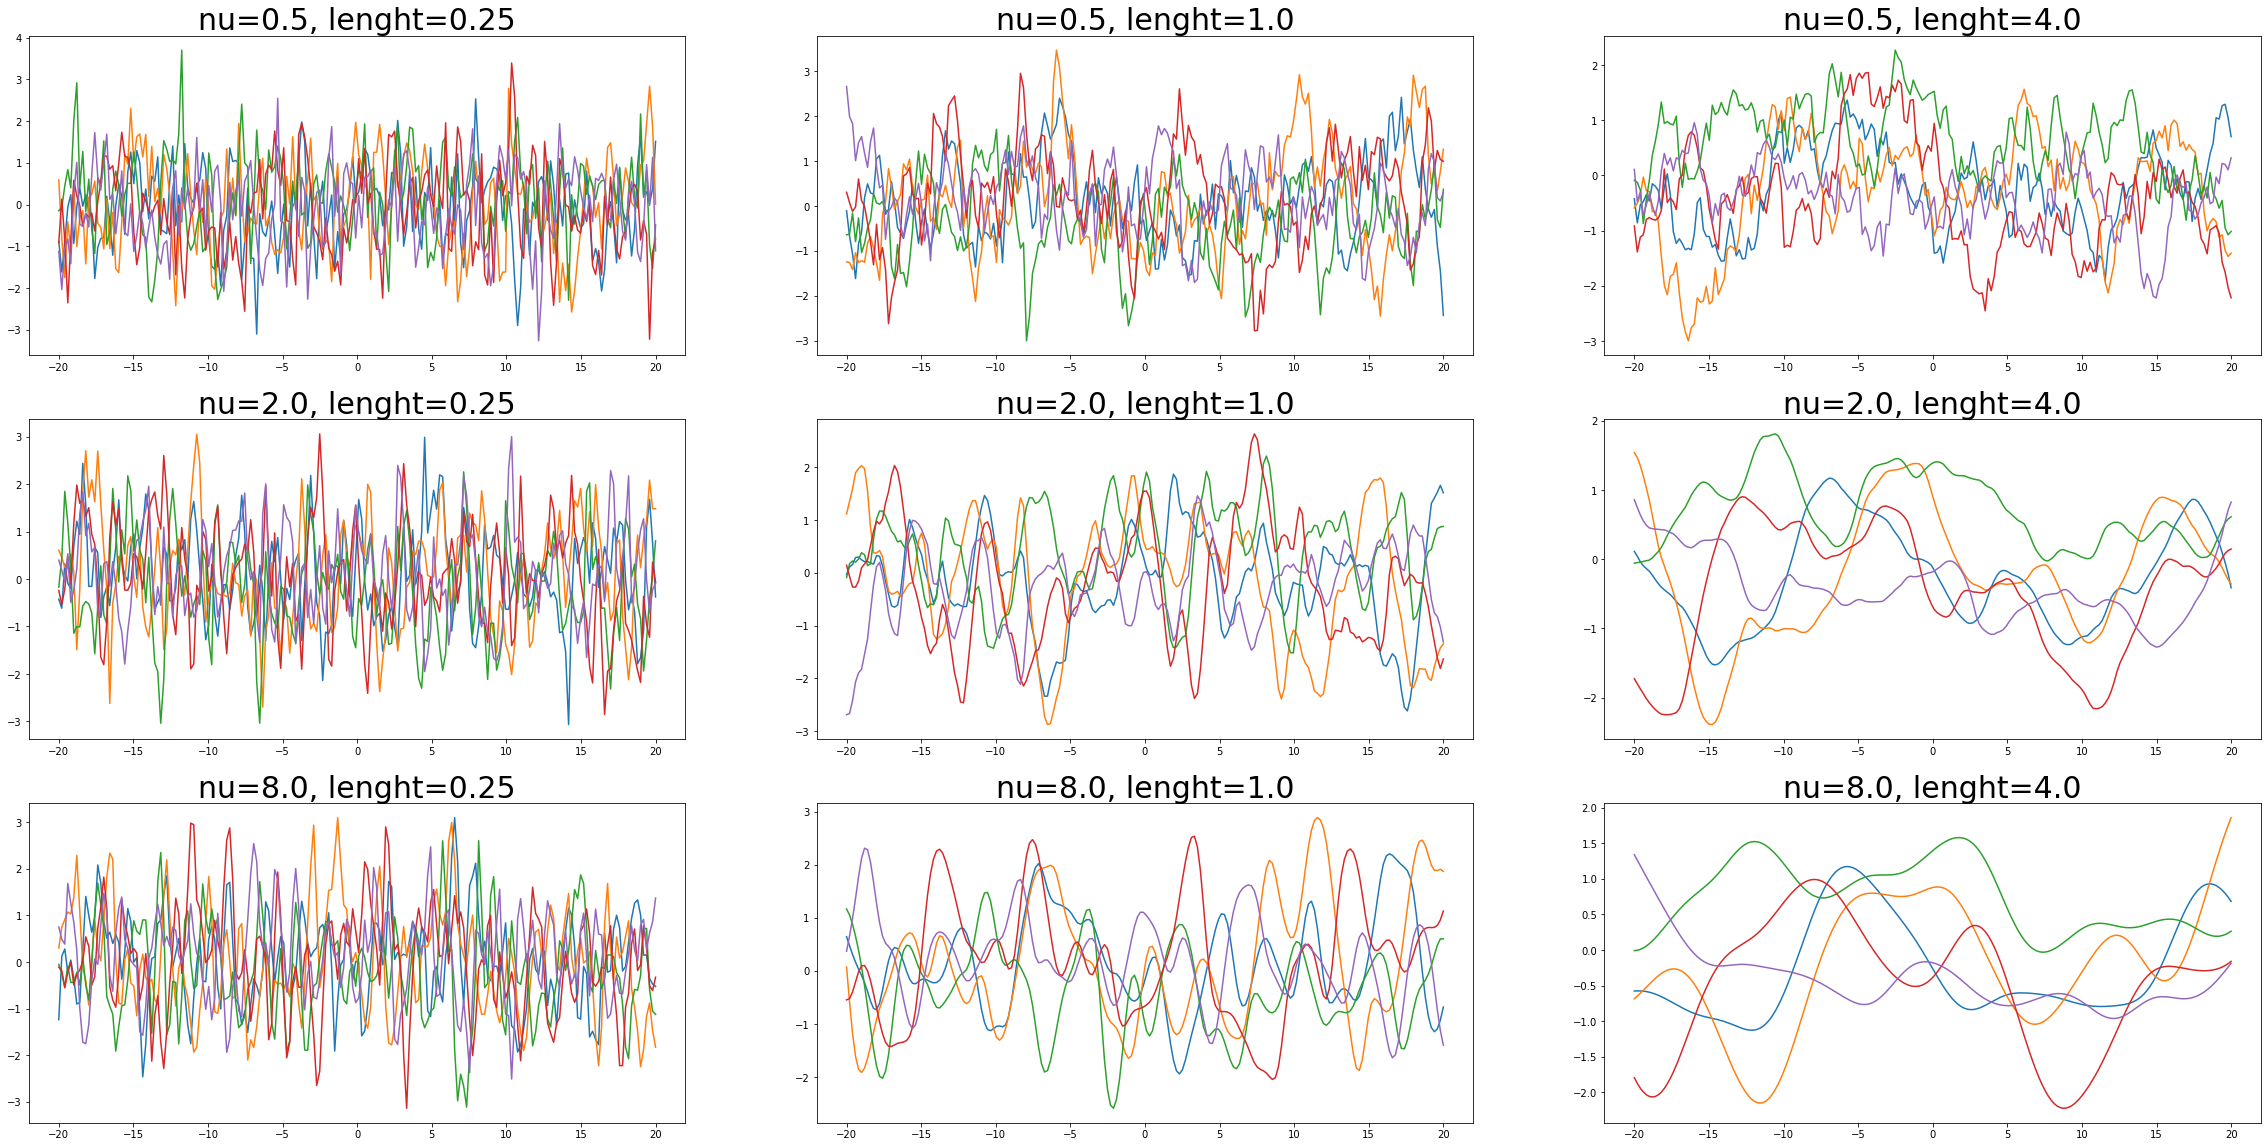

In [8]:
y00 = draw_GP_prior_samples_at_x_grid(x_grid_G, 
                                      mean_func = zero_mean, 
                                      cov_func = partial(general_matern_kernel,nu=0.5,lenght=0.25), 
                                      random_seed=42,
                                      n_samples=5)
y01 = draw_GP_prior_samples_at_x_grid(x_grid_G, 
                                      mean_func = zero_mean, 
                                      cov_func = partial(general_matern_kernel,nu=0.5,lenght=1.0), 
                                      random_seed=42,
                                      n_samples=5)
y02 = draw_GP_prior_samples_at_x_grid(x_grid_G, 
                                      mean_func = zero_mean, 
                                      cov_func = partial(general_matern_kernel,nu=0.5,lenght=4.0), 
                                      random_seed=42,
                                      n_samples=5)
y10 = draw_GP_prior_samples_at_x_grid(x_grid_G, 
                                      mean_func = zero_mean, 
                                      cov_func = partial(general_matern_kernel,nu=2.0,lenght=0.25), 
                                      random_seed=42,
                                      n_samples=5)
y11 = draw_GP_prior_samples_at_x_grid(x_grid_G, 
                                      mean_func = zero_mean, 
                                      cov_func = partial(general_matern_kernel,nu=2.0,lenght=1.0), 
                                      random_seed=42,
                                      n_samples=5)
y12 = draw_GP_prior_samples_at_x_grid(x_grid_G, 
                                      mean_func = zero_mean, 
                                      cov_func = partial(general_matern_kernel,nu=2.0,lenght=4.0), 
                                      random_seed=42,
                                      n_samples=5)
y20 = draw_GP_prior_samples_at_x_grid(x_grid_G, 
                                      mean_func = zero_mean, 
                                      cov_func = partial(general_matern_kernel,nu=8.0,lenght=0.25), 
                                      random_seed=42,
                                      n_samples=5)
y21 = draw_GP_prior_samples_at_x_grid(x_grid_G, 
                                      mean_func = zero_mean, 
                                      cov_func = partial(general_matern_kernel,nu=8.0,lenght=1.0), 
                                      random_seed=42,
                                      n_samples=5)
y22 = draw_GP_prior_samples_at_x_grid(x_grid_G, 
                                      mean_func = zero_mean, 
                                      cov_func = partial(general_matern_kernel,nu=8.0,lenght=4.0), 
                                      random_seed=42,
                                      n_samples=5)

fig, axs = plt.subplots(nrows=3, ncols=3, constrained_layout=False, figsize=(40, 20))
axs[0,0].set_title('nu=0.5, lenght=0.25', fontsize=30)
a = axs[0,0].plot(x_grid_G,y00.T)
axs[0,1].set_title('nu=0.5, lenght=1.0', fontsize=30)
a = axs[0,1].plot(x_grid_G,y01.T)
axs[0,2].set_title('nu=0.5, lenght=4.0', fontsize=30)
a = axs[0,2].plot(x_grid_G,y02.T)

axs[1,0].set_title('nu=2.0, lenght=0.25', fontsize=30)
a = axs[1,0].plot(x_grid_G,y10.T)
axs[1,1].set_title('nu=2.0, lenght=1.0', fontsize=30)
a = axs[1,1].plot(x_grid_G,y11.T)
axs[1,2].set_title('nu=2.0, lenght=4.0', fontsize=30)
a = axs[1,2].plot(x_grid_G,y12.T)

axs[2,0].set_title('nu=8.0, lenght=0.25', fontsize=30)
a = axs[2,0].plot(x_grid_G,y20.T)
axs[2,1].set_title('nu=8.0, lenght=1.0', fontsize=30)
a = axs[2,1].plot(x_grid_G,y21.T)
axs[2,2].set_title('nu=8.0, lenght=4.0', fontsize=30)
a = axs[2,2].plot(x_grid_G,y22.T)

### Exercise 3: Sample from posterior with squared exponential kernels

In [9]:
x_train_N = np.asarray([-2.,    -1.8,   -1.,  1.,  1.8,     2.])
y_train_N = np.asarray([-3.,  0.2224,    3.,  3.,  0.2224, -3.])

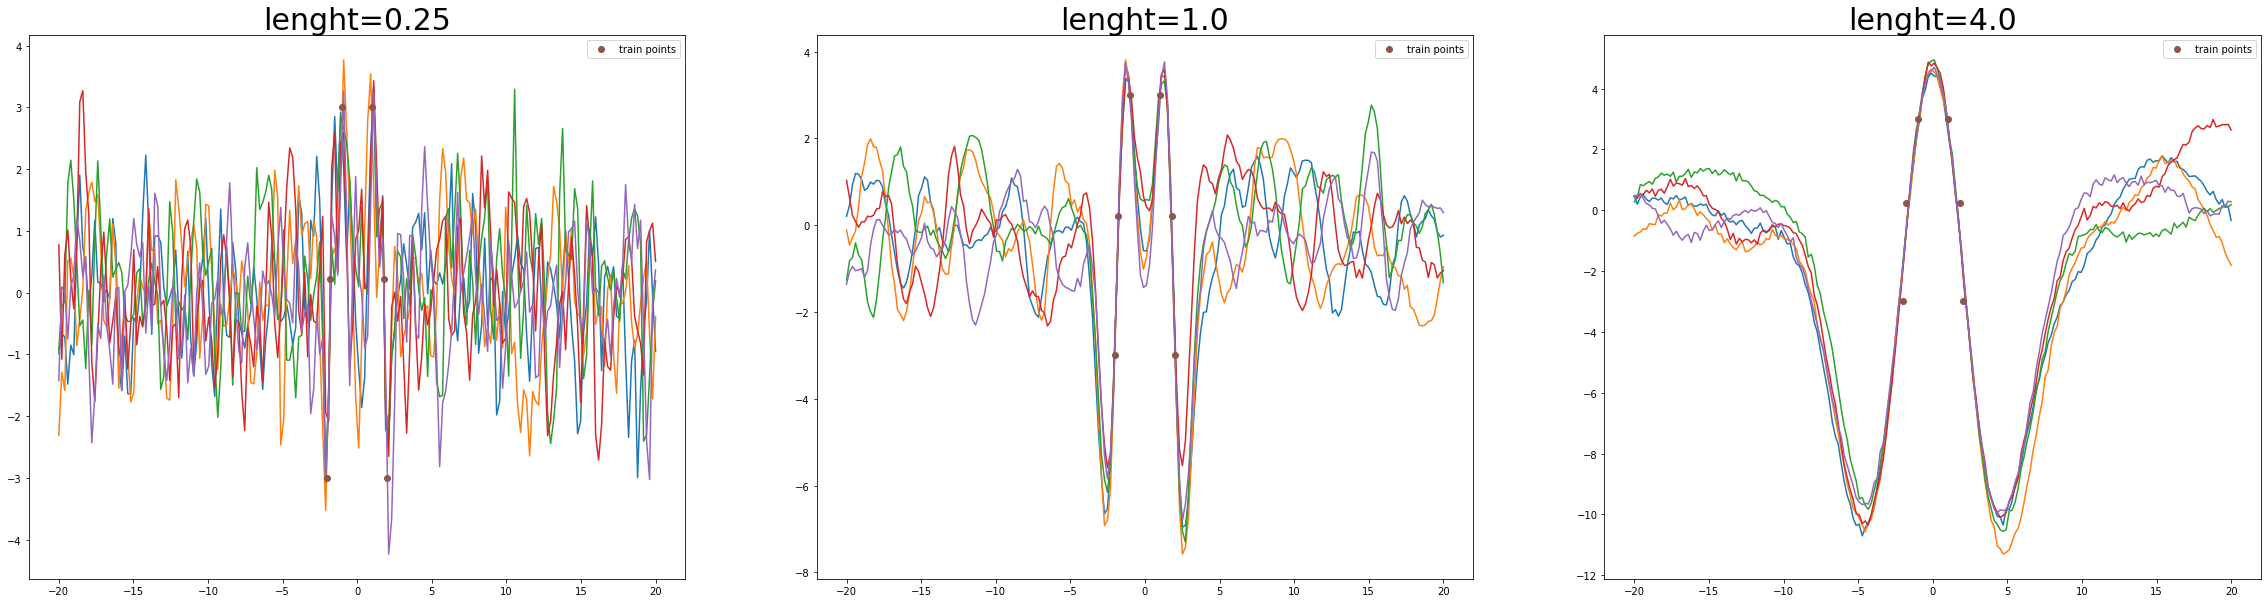

In [11]:
y0 = draw_GP_posterior_samples_at_x_grid(x_train_N, y_train_N, x_grid_G, 
                                        mean_func = zero_mean, 
                                        cov_func = partial(general_squared_exp_kernel,lenght=0.25), 
                                        sigma=0.1,
                                        random_seed=42,
                                        n_samples=5)
y1 = draw_GP_posterior_samples_at_x_grid(x_train_N, y_train_N, x_grid_G, 
                                        mean_func = zero_mean, 
                                        cov_func = partial(general_squared_exp_kernel,lenght=1.0), 
                                        sigma=0.1,
                                        random_seed=42,
                                        n_samples=5)
y2 = draw_GP_posterior_samples_at_x_grid(x_train_N, y_train_N, x_grid_G, 
                                        mean_func = zero_mean, 
                                        cov_func = partial(general_squared_exp_kernel,lenght=4.0), 
                                        sigma=0.1,
                                        random_seed=42,
                                        n_samples=5)

fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=False, figsize=(40, 10))
axs[0].set_title('lenght=0.25', fontsize=30)
a = axs[0].plot(x_grid_G,y0.T)

axs[1].set_title('lenght=1.0', fontsize=30)
a = axs[1].plot(x_grid_G,y1.T)
axs[2].set_title('lenght=4.0', fontsize=30)
a = axs[2].plot(x_grid_G,y2.T)

for ax in axs:
    a = ax.plot(x_train_N,y_train_N,'o',label="train points")
    ax.legend()

### Exercise 4: Sample from posterior with Matern kernels

/Users/ldalessi/anaconda3/envs/bdl_2019f_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply


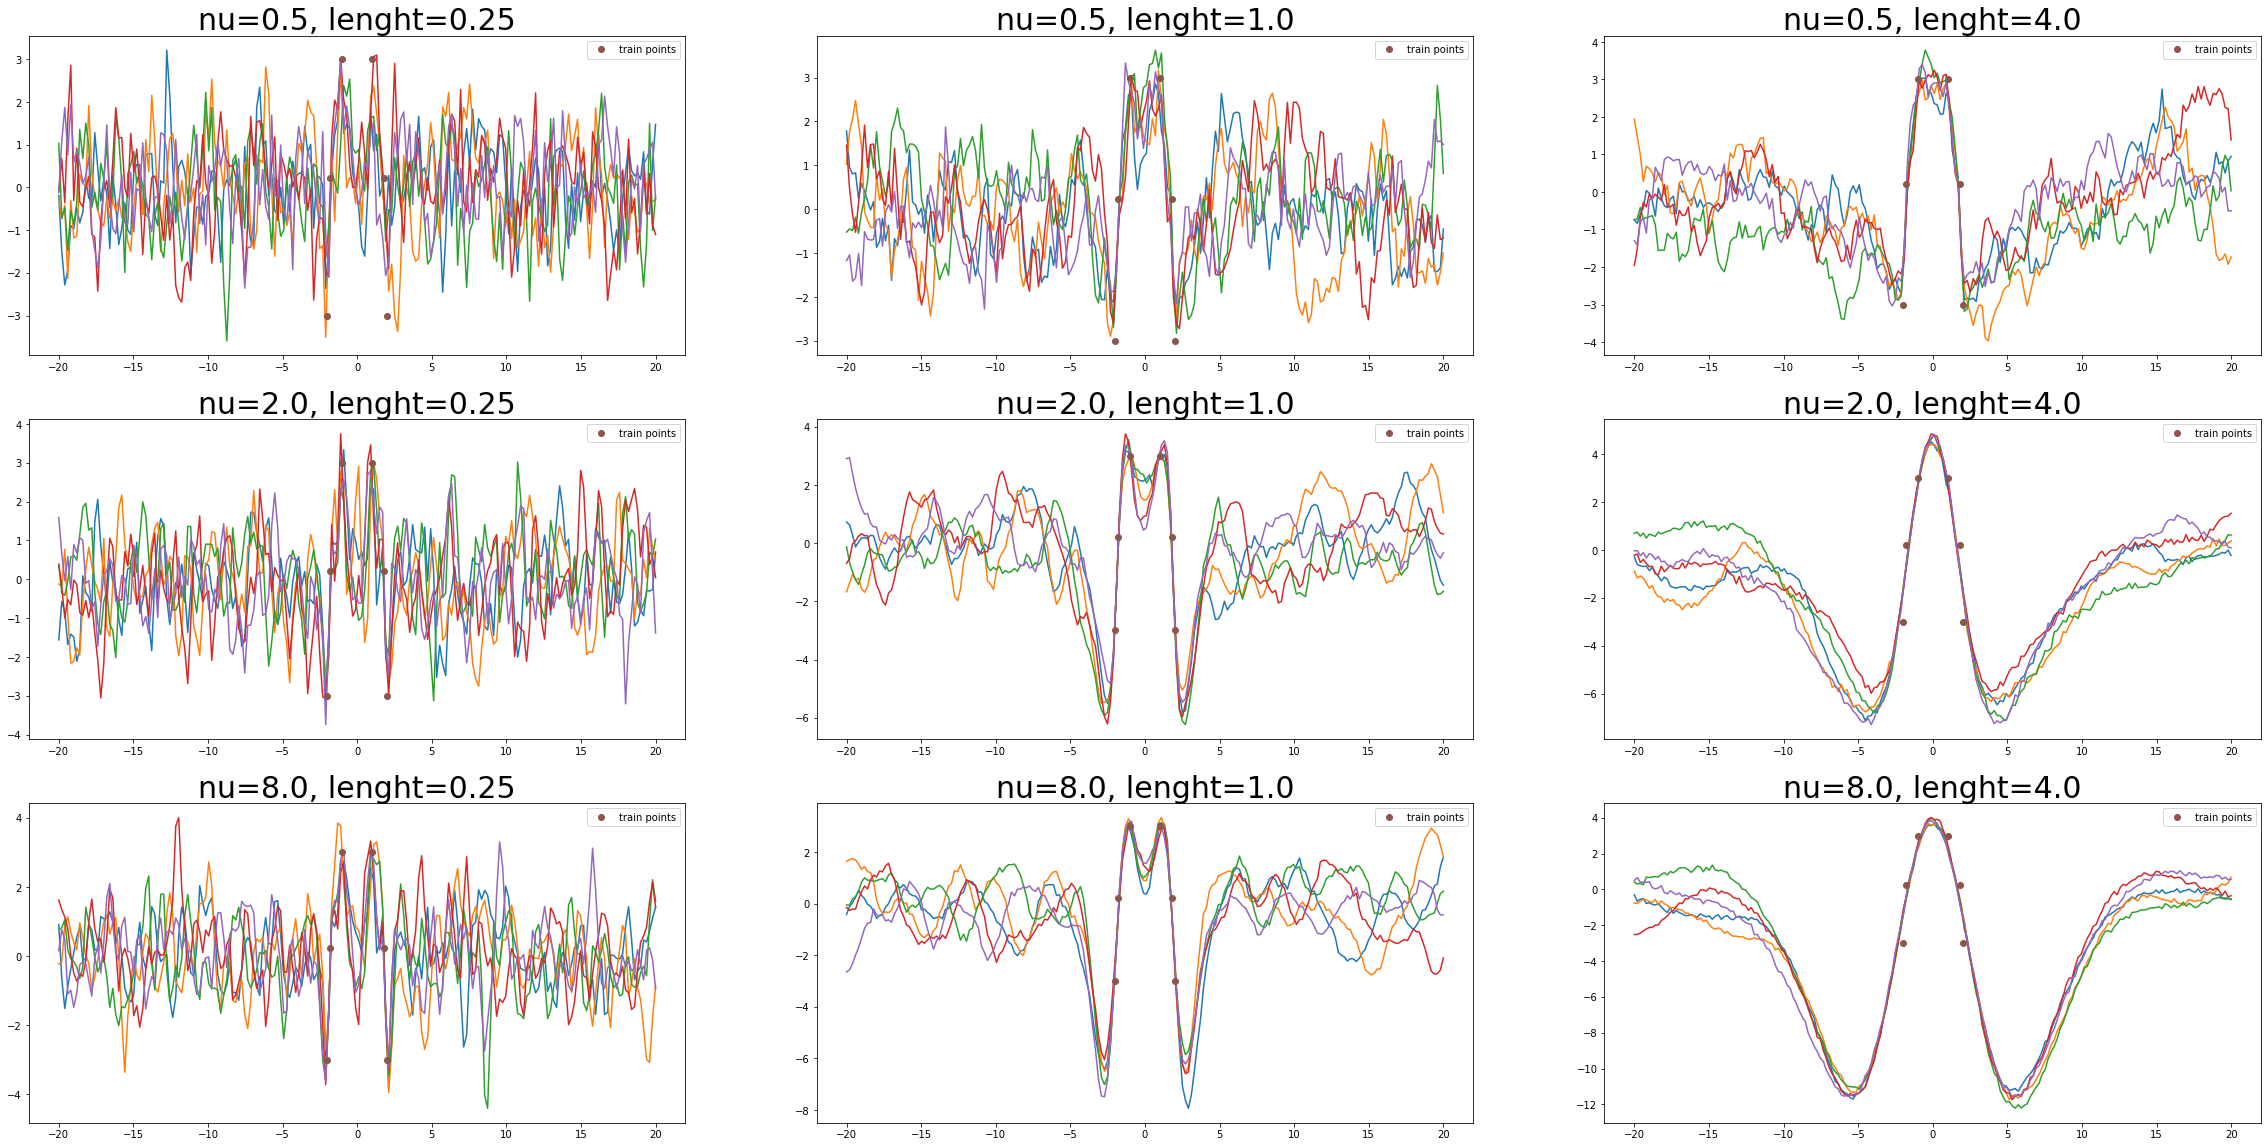

In [12]:

y00 = draw_GP_posterior_samples_at_x_grid(x_train_N, y_train_N, x_grid_G, 
                                          mean_func = zero_mean, 
                                          cov_func = partial(general_matern_kernel,nu=0.5,lenght=0.25), 
                                          sigma=0.1,
                                          random_seed=42,
                                          n_samples=5)
y01 = draw_GP_posterior_samples_at_x_grid(x_train_N, y_train_N, x_grid_G, 
                                          mean_func = zero_mean, 
                                          cov_func = partial(general_matern_kernel,nu=0.5,lenght=1.0), 
                                          sigma=0.1,
                                          random_seed=42,
                                          n_samples=5)
y02 = draw_GP_posterior_samples_at_x_grid(x_train_N, y_train_N, x_grid_G, 
                                          mean_func = zero_mean, 
                                          cov_func = partial(general_matern_kernel,nu=0.5,lenght=4.0), 
                                          sigma=0.1,
                                          random_seed=42,
                                          n_samples=5)
y10 = draw_GP_posterior_samples_at_x_grid(x_train_N, y_train_N, x_grid_G, 
                                          mean_func = zero_mean, 
                                          cov_func = partial(general_matern_kernel,nu=2.0,lenght=0.25), 
                                          sigma=0.1,
                                          random_seed=42,
                                          n_samples=5)
y11 = draw_GP_posterior_samples_at_x_grid(x_train_N, y_train_N, x_grid_G, 
                                          mean_func = zero_mean, 
                                          cov_func = partial(general_matern_kernel,nu=2.0,lenght=1.0), 
                                          sigma=0.1,
                                          random_seed=42,
                                          n_samples=5)
y12 = draw_GP_posterior_samples_at_x_grid(x_train_N, y_train_N, x_grid_G, 
                                          mean_func = zero_mean, 
                                          cov_func = partial(general_matern_kernel,nu=2.0,lenght=4.0), 
                                          sigma=0.1,
                                          random_seed=42,
                                          n_samples=5)
y20 = draw_GP_posterior_samples_at_x_grid(x_train_N, y_train_N, x_grid_G, 
                                          mean_func = zero_mean, 
                                          cov_func = partial(general_matern_kernel,nu=8.0,lenght=0.25), 
                                          sigma=0.1,
                                          random_seed=42,
                                          n_samples=5)
y21 = draw_GP_posterior_samples_at_x_grid(x_train_N, y_train_N, x_grid_G, 
                                          mean_func = zero_mean, 
                                          cov_func = partial(general_matern_kernel,nu=8.0,lenght=1.0), 
                                          sigma=0.1,
                                          random_seed=42,
                                          n_samples=5)
y22 = draw_GP_posterior_samples_at_x_grid(x_train_N, y_train_N, x_grid_G, 
                                          mean_func = zero_mean, 
                                          cov_func = partial(general_matern_kernel,nu=8.0,lenght=4.0), 
                                          sigma=0.1,
                                          random_seed=42,
                                          n_samples=5)

fig, axs = plt.subplots(nrows=3, ncols=3, constrained_layout=False, figsize=(40, 20))
axs[0,0].set_title('nu=0.5, lenght=0.25', fontsize=30)
a = axs[0,0].plot(x_grid_G,y00.T)
axs[0,1].set_title('nu=0.5, lenght=1.0', fontsize=30)
a = axs[0,1].plot(x_grid_G,y01.T)
axs[0,2].set_title('nu=0.5, lenght=4.0', fontsize=30)
a = axs[0,2].plot(x_grid_G,y02.T)

axs[1,0].set_title('nu=2.0, lenght=0.25', fontsize=30)
a = axs[1,0].plot(x_grid_G,y10.T)
axs[1,1].set_title('nu=2.0, lenght=1.0', fontsize=30)
a = axs[1,1].plot(x_grid_G,y11.T)
axs[1,2].set_title('nu=2.0, lenght=4.0', fontsize=30)
a = axs[1,2].plot(x_grid_G,y12.T)

axs[2,0].set_title('nu=8.0, lenght=0.25', fontsize=30)
a = axs[2,0].plot(x_grid_G,y20.T)
axs[2,1].set_title('nu=8.0, lenght=1.0', fontsize=30)
a = axs[2,1].plot(x_grid_G,y21.T)
axs[2,2].set_title('nu=8.0, lenght=4.0', fontsize=30)
a = axs[2,2].plot(x_grid_G,y22.T)

for col in range(3):
    for row in range(3):
        a = axs[row,col].plot(x_train_N,y_train_N,'o',label="train points")
        axs[row,col].legend()
    